In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [3]:
df=pd.read_csv('fer2013.csv')

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


<h3> Lets select the interested labels because of GPU  and also take all images per category</h3>

In [5]:
interested_labels=[3,4]

df=df[df['emotion'].isin(interested_labels)]

In [6]:
df['emotion'].dtype

dtype('int64')

In [7]:
df.shape

(15066, 3)

In [8]:
df['emotion'].value_counts()

emotion
3    8989
4    6077
Name: count, dtype: int64

In [9]:
df['Usage'].value_counts()

Usage
Training       12045
PublicTest      1548
PrivateTest     1473
Name: count, dtype: int64

<h4> Since we don't need the usage column because it is not relevant to us so we will remove usage column and we have six type of emotions 0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'. the majority of a data belongs to happiness and sadness emotion so we will go these emotions because of GPU concern </h3>

In [10]:
df.drop('Usage',axis=1,inplace=True)

In [11]:
df.head()

,emotion,pixels
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...
14,3,4 2 13 41 56 62 67 87 95 62 65 70 80 107 127 1...


In [12]:
df.shape

(15066, 2)

In [13]:
df.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [14]:
df.duplicated().sum()

332

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.duplicated().sum()

0

In [17]:
df['emotion'].value_counts()

emotion
3    8800
4    5934
Name: count, dtype: int64

<h3> So, lets visualize some data </h3>

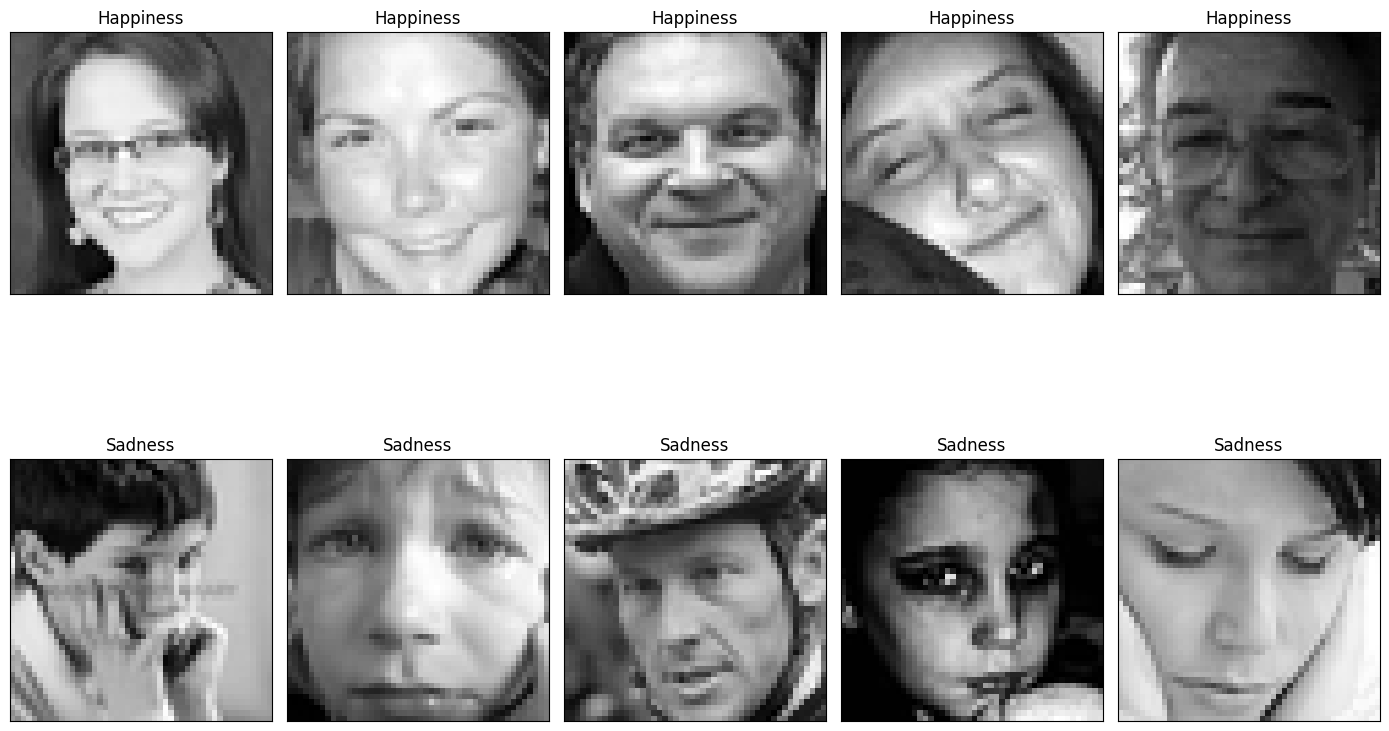

In [18]:
emotion_label_to_text = {3: 'Happiness', 4: 'Sadness'}
plt.figure(figsize=(14, 14))

k = 1

# Iterate through both emotions
for emotion in emotion_label_to_text.keys():
    df_emotion = df[df.emotion == emotion]
    num_images = min(5, len(df_emotion))  # Display up to 5 images for each emotion

    for i in range(num_images):
        px = df_emotion.pixels.iloc[i]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        ax = plt.subplot(2, 5, k)  # 2 rows and 5 columns grid
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[emotion])
        plt.tight_layout()
        k += 1


<h3> SO lets prepare the data for the model </h3>

In [19]:
# Converting the pixels into arrays and stacked it
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)    # '45 46 47'   [45  46 47] [[23 89 98][34 56 687]

In [20]:
# Encode the labels of images
lb=LabelEncoder()
img_labels=lb.fit_transform(df.emotion)
img_labels=to_categorical(img_labels)

In [ ]:
print(img_labels)

In [21]:
img_labels.shape

(14734, 2)

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch  # Assuming you're using RandomSearch
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, test_size=0.2, random_state=35)

# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv_1_units', min_value=32, max_value=256, step=32),
               (3, 3), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D((2, 2)),
        Dropout(hp.Choice(name='dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])),
        Flatten(),
        Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        Dense(2, activation='sigmoid')  # Adjust num_classes for your problem
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=4,
    directory='Musical1',
    project_name='Facial1'
)

# Run the hyperparameter search
tuner.search(train_datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

# Check if any models were found
if tuner.oracle.get_best_trials(num_trials=1):
    model = tuner.get_best_models(num_models=1)[0]
    # Further code to evaluate or use the model
else:
    print("No models were found. Please check the search process and data.")

Trial 5 Complete [00h 20m 37s]
val_accuracy: 0.5907703042030334

Best val_accuracy So Far: 0.6661011129617691
Total elapsed time: 04h 52m 06s


c:\Users\Probook\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
acc,loss=model.evaluate(X_test,y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7205 - loss: 0.5635


In [33]:
acc,loss=model.evaluate(X_train,y_train)

369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.7139 - loss: 0.5501


<h2> lets make a neural network with Batch Normalization </h2>

In [34]:
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00004,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.4,
    patience=6,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [36]:
# define a function for building neural networks
from tensorflow.keras import optimizers
def build_net():
    """
    Remember its a deep neural network, I used dropout and Batch normalization in order to reduce overfitting
    
    """
    net=Sequential()
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(48,48,1),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
    
    net.add(
        Dense(
            128,
            activation='relu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            2,
            activation='sigmoid',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [37]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 20


model = build_net() 
history = model.fit(
    train_datagen.flow(X_train,y_train,batch_size=batch_size),
    validation_data=(X_test,y_test),
    epochs=epochs,
    callbacks=callbacks
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,394,946 (9.14 MB)

 Trainable params: 2,392,898 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 319s 851ms/step - accuracy: 0.5608 - loss: 0.8940 - val_accuracy: 0.6423 - val_loss: 0.6373 - learning_rate: 0.0010
Epoch 2/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 302s 819ms/step - accuracy: 0.6201 - loss: 0.6905 - val_accuracy: 0.6790 - val_loss: 0.5859 - learning_rate: 0.0010
Epoch 3/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 301s 816ms/step - accuracy: 0.6528 - loss: 0.6363 - val_accuracy: 0.6722 - val_loss: 0.6496 - learning_rate: 0.0010
Epoch 4/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 304s 822ms/step - accuracy: 0.7166 - loss: 0.5577 - val_accuracy: 0.6949 - val_loss: 0.7514 - learning_rate: 0.0010
Epoch 5/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 319s 863ms/step - accuracy: 0.7691 - loss: 0.4872 - val_accuracy: 0.8381 - val_loss: 0.3604 - learning_rate: 0.0010
Epoch 6/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 311s 843ms/step - accuracy: 0.8022 - loss: 0.4240 - val_accuracy: 0.8470 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 7/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 311s 843ms/step - accura

<h3> Checking the accuracy </h3>

In [38]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 829ms/step - accuracy: 0.9269 - loss: 0.1861
test loss, test acc: [0.19504109025001526, 0.9229725003242493]


In [39]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step


In [40]:
!pip install scikit-plot


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import matplotlib.pyplot as plt

def plot_history(history):
  """Plots accuracy/loss graphs for training dataset and validation dataset."""
  
  fig, axs = plt.subplots(2)

  # Plot accuracy
  axs[0].plot(history.history['accuracy'], label='train_acc')
  axs[0].plot(history.history['val_accuracy'], label='val_acc')
  axs[0].set_title('Accuracy')
  axs[0].legend(loc='lower right')

  # Plot loss
  axs[1].plot(history.history['loss'], label='train_loss')
  axs[1].plot(history.history['val_loss'], label='val_loss')
  axs[1].set_title('Loss')
  axs[1].legend(loc='upper right')

  plt.show()


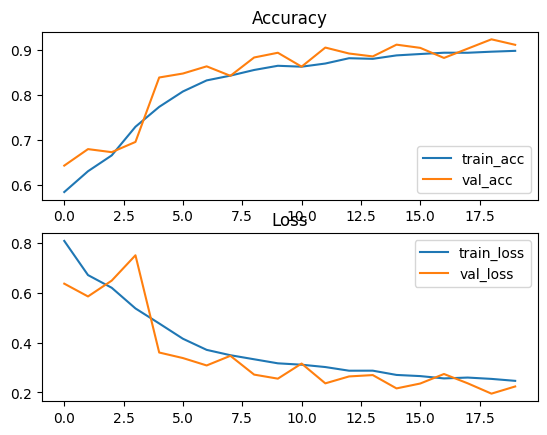

In [42]:
plot_history(history)

In [43]:
y_pred = model.predict(X_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 322ms/step


Confusion Matrix:
[[1613  128]
 [  99 1107]]


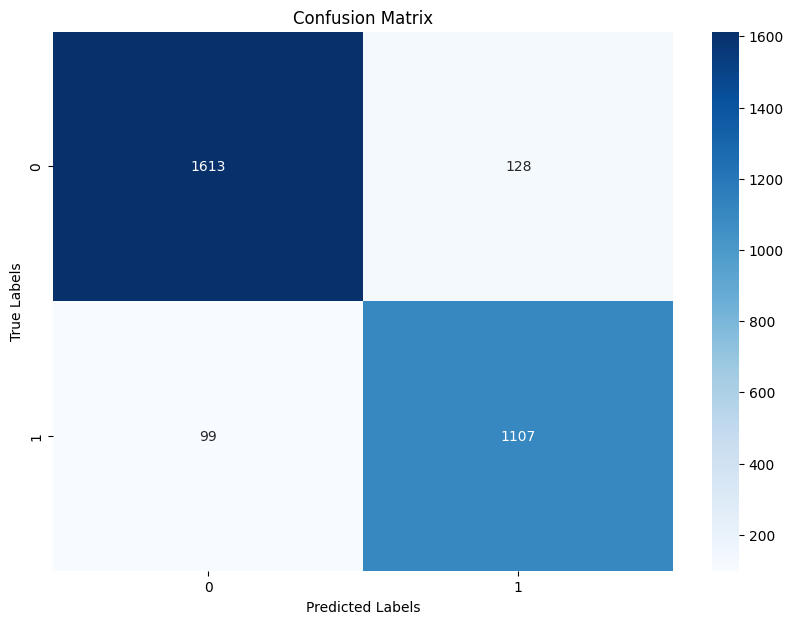

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1741
           1       0.90      0.92      0.91      1206

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



In [44]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred contains predicted class probabilities
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (assuming multiclass)

# Convert one-hot encoded y_test back to class labels if necessary
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test_labels, y_pred_labels)
print("Classification Report:")
print(class_report)


In [45]:
model.save('Final_model.h5')